Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Introduction

# Importing Libraries

Here are the libraries that we are going to use for this project.

In [80]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import f_oneway


# Accessing CSV file

We need to access the given CSV file so we do this below.

In [81]:
#This is the name of the file path
#file_path = "/datasets/car_data.csv"
file_path = "/Users/tanner/Downloads/car_data.csv"

#This is the csv file that contains all of the information that we will use for this project
rusty_df = pd.read_csv(file_path)

# Formatting the Data

## Inspecting the CSV file for General Information

In [82]:
#Here is the general info for the file
print(rusty_df.info(), "\n\n", rusty_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [83]:
#Here are the statistical measurements of the data
print(rusty_df.describe())

               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

## Dropping NumberOfPictures Column

Since this column only contains 0's, it will be no use of us for statistical anaylsis nor model training / testing.

In [84]:
#Here we drop the NumberOfPictures column
rusty_df.drop(columns=['NumberOfPictures'], inplace=True)

## Changing Various Columns to DateTime Format

In [85]:
#Here are the first 10 entries of the DateCrawled, DateCreated, and Last seen Columns

#Datecrawled
print(rusty_df['DateCrawled'].head(5))

#DateCreated
print(rusty_df['DateCreated'].head(5))

#LastSeen
print(rusty_df['LastSeen'].head(5))

0    24/03/2016 11:52
1    24/03/2016 10:58
2    14/03/2016 12:52
3    17/03/2016 16:54
4    31/03/2016 17:25
Name: DateCrawled, dtype: object
0    24/03/2016 00:00
1    24/03/2016 00:00
2    14/03/2016 00:00
3    17/03/2016 00:00
4    31/03/2016 00:00
Name: DateCreated, dtype: object
0    07/04/2016 03:16
1    07/04/2016 01:46
2    05/04/2016 12:47
3    17/03/2016 17:40
4    06/04/2016 10:17
Name: LastSeen, dtype: object


We need to convert these columns into datetime format.

In [86]:
"""
Here we convert the aformentioned columns to datetime format, and the month will be displayed first in our datetime
objects since that is the standard description of a date in the US.
"""

#Here we convert the DateCrawled column to datetime format
rusty_df['DateCrawled'] = pd.to_datetime(rusty_df['DateCrawled'], errors = 'coerce', dayfirst = True)

#Here we convert the DateCreated column to datetime format
rusty_df['DateCreated'] = pd.to_datetime(rusty_df['DateCreated'], errors='coerce', dayfirst = True)

#Here we convert the LastSeen column to datetime format
rusty_df['LastSeen'] = pd.to_datetime(rusty_df['LastSeen'], errors='coerce', dayfirst=True)

Let's check to see if the changes were made

In [87]:
#Check to see if DateCrawled, DateCreated, and LastSeen were converted to datetime format correctly
print(rusty_df[['DateCrawled', 'DateCreated', 'LastSeen']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DateCrawled  354369 non-null  datetime64[ns]
 1   DateCreated  354369 non-null  datetime64[ns]
 2   LastSeen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB
None


## Checking the Years for Registration Year of Vehicle

Here are the first few entries of our RegistrationYear feature.

In [88]:
print(rusty_df['RegistrationYear'].head(10))

0    1993
1    2011
2    2004
3    2001
4    2008
5    1995
6    2004
7    1980
8    2014
9    1998
Name: RegistrationYear, dtype: int64


Let's see all of the unique registration year values we have in our dataset—-assuming it is not too large.

In [89]:
#Printing the unique registration years from earliest to latest
print(rusty_df['RegistrationYear'].sort_values(ascending=False).unique())

[9999 9996 9450 9229 9000 8888 8500 8455 8200 8000 7800 7500 7100 7000
 6500 6000 5911 5900 5600 5555 5300 5000 4800 4500 4100 4000 3800 3700
 3500 3200 3000 2900 2800 2500 2290 2222 2200 2066 2019 2018 2017 2016
 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988
 1987 1986 1985 1984 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974
 1973 1972 1971 1970 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960
 1959 1958 1957 1956 1955 1954 1953 1952 1951 1950 1949 1948 1947 1946
 1945 1944 1943 1942 1941 1940 1938 1937 1936 1935 1934 1933 1932 1931
 1930 1929 1928 1927 1925 1923 1920 1919 1915 1910 1800 1688 1602 1600
 1500 1400 1300 1255 1253 1234 1200 1111 1039 1001 1000]


There are a few reasons why many of these values will serve as neither good training nor testing data. First, we have recorded time periods where automobiles did not exist, e.g., 1000 AD. Secondly, we have particular years that have not occured yet; for example, the year 9999 AD is past the current year by several millenia. Therefore, we are going to have to remove the rows that do not fit well for our model. In addition to our filtering, classic cars (for this project, cars registered by 1990) will also be removed. Classic cars are often priced differently than typical newer cars in today's time. Therefore, to achieve better pricing predictions for relatively modern cars with standard pricing methods, we will filter our classic cars.

In [90]:
#We are going to keep cars that were registered between 1990 and 2019
rusty_df = rusty_df[(rusty_df['RegistrationYear'] >= 1990) & (rusty_df['RegistrationYear'] <= 2019)].reset_index(drop = True)

Let's check to see if the changes were made.

In [91]:
print(rusty_df['RegistrationYear'].sort_values(ascending=False).unique())

[2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006
 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992
 1991 1990]


## Inspecting Power Values

Let's see the general statistics for the power feature in our data.

In [92]:
print(rusty_df['Power'].describe())

count    344595.000000
mean        110.805772
std         187.221179
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


There are values of horsepower (HP) that are not realistic values. Observing the max value of 20000 and a minimum value of 0, these are likely typos, glitches, missign entries, or something related. 300 HP for a car is a high value compared to most everyday cars. Moreover, in terms of sports cars, values can range from 300 - 600 on average. Let's set the maximum HP to 600 for our power feature.

In [93]:
#Here we filter out any row from our dataframe that has a horsepower of anything strictly larger than 600
rusty_df = rusty_df[rusty_df['Power'] <= 600].reset_index(drop = True)

#Let us observe the general statistics now
print(rusty_df['Power'].describe())

count    344235.000000
mean        107.285686
std          63.081177
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64


We lost a fraction of our data after the removal of any row with horsepower greater than 600. Our mean dropped by 4 points roughly and our standard deviation improved considerably. However, we still have a minimum value of 0. Before we observe the distribution of the power feature, let's see the frequency of the of our top values to get a numerical sense of what is going on.

In [94]:
print(rusty_df['Power'].value_counts().head())

Power
0      37768
75     23660
60     15660
150    14491
101    13236
Name: count, dtype: int64


Clearly we have multiple data points whose horsepower is zero. Removing the rows with this HP would remove more data than ideal so we need to impute the data with a central tendency, likely the mean or medium. Let's take a look at the distribution to see if we should impute the column with.

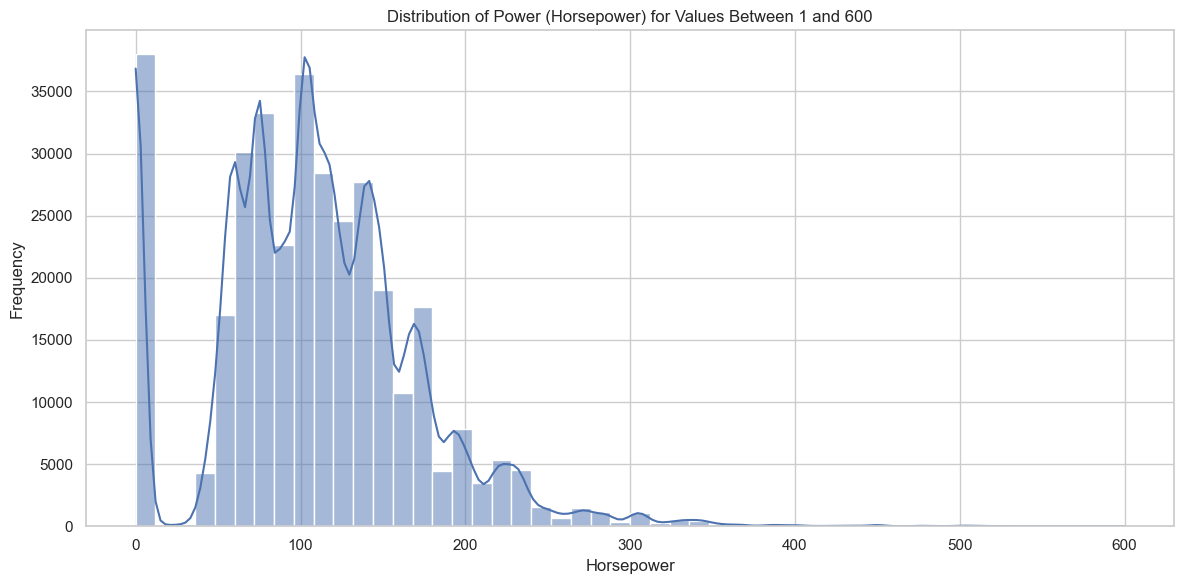

In [95]:
#Setting up the plot
plt.figure(figsize=(12, 6))
sns.histplot(rusty_df['Power'], bins=50, kde=True)
plt.title('Distribution of Power (Horsepower) for Values Between 1 and 600')
plt.xlabel('Horsepower')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

There are outliers for this particular distribution, which could disrupt the positioning of the mean. To see the best choice for imputation, we will replace the 0's of our power feature with both the mean and median of our distribution and see which distribution gives better statistics.

In [96]:
#First, let us replace all of the zeros with null values; we can do this since there are no null values within this column
rusty_df['Power'].replace(0, np.nan, inplace = True)

#Now we can replace all of our null values with the mean and median. We'll be sure to make copies of the dataframe beforehand

#Making copies of the dataframe
mean_df = rusty_df.copy(deep = True)
median_df = rusty_df.copy(deep = True)

#Imputing null values with mean and median
mean_df['Power'] = mean_df['Power'].fillna(mean_df['Power'].mean())
median_df['Power'] = median_df['Power'].fillna(median_df['Power'].median())

#Now let's see some of the stats for these copies
print(mean_df['Power'].describe())
print(median_df['Power'].describe())

count    344235.000000
mean        120.507226
std          50.603841
min           1.000000
25%          84.000000
50%         118.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64
count    344235.000000
mean        119.354418
std          50.710281
min           1.000000
25%          84.000000
50%         110.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64


/var/folders/s0/ttxls7cd5w1g444b5l_mfp1c0000gp/T/ipykernel_29288/1513582792.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rusty_df['Power'].replace(0, np.nan, inplace = True)


Regardless of whether the data is imputed by the mean or median, the values are roughly the same, even for the mean itself. Thus, choosing either value to use is fine. We'll inspect the distributions just for context to be sure.

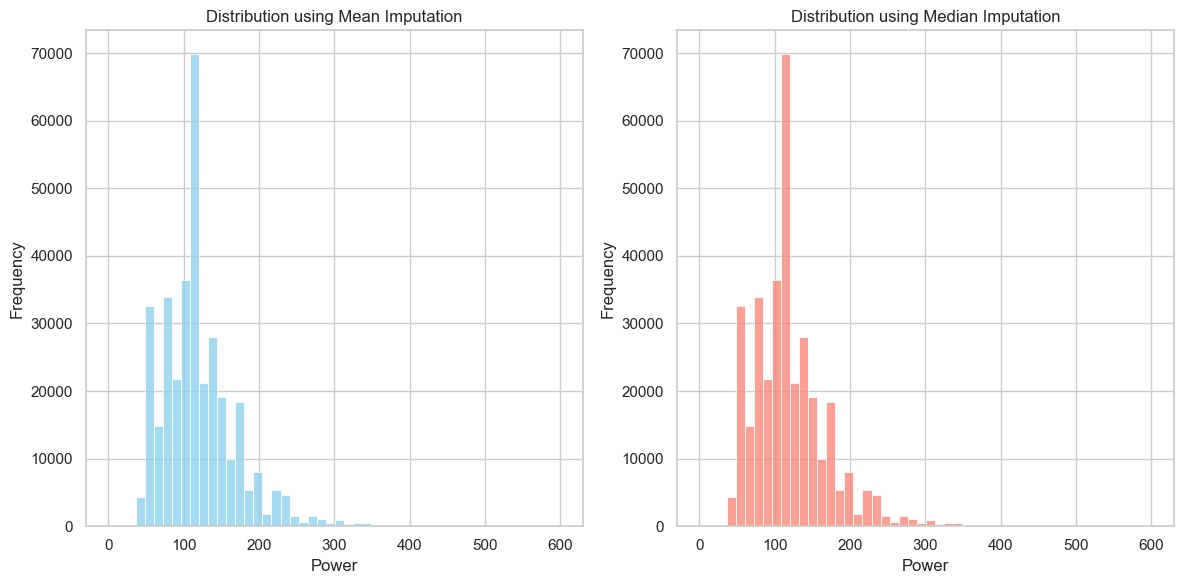

In [97]:
#Setting up the plot figure
plt.figure(figsize=(12, 6))

#Plotting the mean-imputed data
plt.subplot(1,2,1)
sns.histplot(mean_df['Power'], bins = 50, color='skyblue')
plt.title('Distribution using Mean Imputation')
plt.xlabel('Power')
plt.ylabel('Frequency')

#Plotting the median-imputted data
plt.subplot(1,2,2)
sns.histplot(median_df['Power'], bins=50, color='salmon')
plt.title('Distribution using Median Imputation')
plt.xlabel("Power")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Since the distributions are virtually the same, imputing the power column with the mean is sufficient.

In [98]:
#Let's check to ensure that the indices of the origial dataframe and the mean imputed dataframe have the same index
(rusty_df.index == mean_df.index).all()

np.True_

In [99]:
#Now let's replace the original dataframe power feature with the feature of the imputed data
rusty_df['Power'] = mean_df['Power']

Let's check the statistics of the power column just to be sure the changes were made.

In [100]:
print(rusty_df['Power'].describe())

count    344235.000000
mean        120.507226
std          50.603841
min           1.000000
25%          84.000000
50%         118.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64


## Replacing Categorical Features with Mode

Here are the first few entries of our categorical feature that we are likely going to use with our model later.

In [101]:
#A list of our categorical columns
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

#Here are some of the values in our categorical columns
print(rusty_df[categorical_features].head(5))

  VehicleType Gearbox  Model  FuelType NotRepaired
0         NaN  manual   golf    petrol         NaN
1       coupe  manual    NaN  gasoline         yes
2         suv    auto  grand  gasoline         NaN
3       small  manual   golf    petrol          no
4       small  manual  fabia  gasoline          no


Let's check to see the number of duplicates that are in these columns.

In [102]:
print(rusty_df[categorical_features].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344235 entries, 0 to 344234
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  307972 non-null  object
 1   Gearbox      325999 non-null  object
 2   Model        326242 non-null  object
 3   FuelType     313178 non-null  object
 4   NotRepaired  276397 non-null  object
dtypes: object(5)
memory usage: 13.1+ MB
None


Since we are working with categorical columns that contain thousands of null entries, we need to impute them with their corresponding modes.

In [103]:
#This for loop will impute the mode for the null values in each respective feature
for feature in categorical_features:
    if rusty_df[feature].isnull().sum() > 0:
        mode_value = rusty_df[feature].mode()[0]
        rusty_df[feature].fillna(mode_value, inplace = True)

/var/folders/s0/ttxls7cd5w1g444b5l_mfp1c0000gp/T/ipykernel_29288/2312664234.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rusty_df[feature].fillna(mode_value, inplace = True)


Let's check to ensure that there we have only valid entries in our categorical columns.

In [104]:
print(rusty_df[categorical_features].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344235 entries, 0 to 344234
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  344235 non-null  object
 1   Gearbox      344235 non-null  object
 2   Model        344235 non-null  object
 3   FuelType     344235 non-null  object
 4   NotRepaired  344235 non-null  object
dtypes: object(5)
memory usage: 13.1+ MB
None


## Checking Registration Month Featue

Let's check the first few entire of our registration month column.

In [105]:
print(rusty_df['RegistrationMonth'].head(10))

0     0
1     5
2     8
3     6
4     7
5    10
6     8
7     8
8     0
9    12
Name: RegistrationMonth, dtype: int64


Though registration year could certainly affect the pricing of a car, the month may not have as great of an impact. Let's check to see the correlation between the month feature and the pricing of a car. If the correlation is low, we will drop this column and not use it as a feature.

In [106]:
#Since the many missing entries '0', we need to replace those with null values and drop them to find the pearson correlation

#Make a copy of our dataframe for testing
correlation_test_df = rusty_df.copy()

#Replacing the 0's with null values
correlation_test_df['RegistrationMonth'] = correlation_test_df['RegistrationMonth'].astype('Int64').replace(0, pd.NA)

#Calculating the correlation between registration month and vehicle pricing; we drop any row that contains a null registration month for more accurate results
correlation = correlation_test_df[['RegistrationMonth', 'Price']].dropna().corr().loc['RegistrationMonth', 'Price']

#Result
correlation

np.float64(0.013931835441271011)

We see that there is a weak positive correlation between registration month of a car and it's value. Let's check take a look at the distribution.

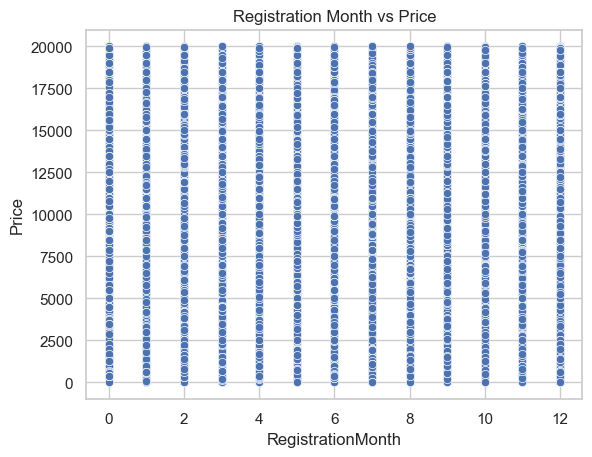

In [107]:
#Scatterplot to see what visual correlation is between registration month and price
sns.scatterplot(data=rusty_df, x = 'RegistrationMonth', y = 'Price')
plt.title('Registration Month vs Price')
plt.show()

Clearly, there is not a discernable pattern here. This is likely due to the fact that this is a categorical column and there are many values per category. Let's visualize the distribution using a boxplot for each category. This may help to see a particular pattern.

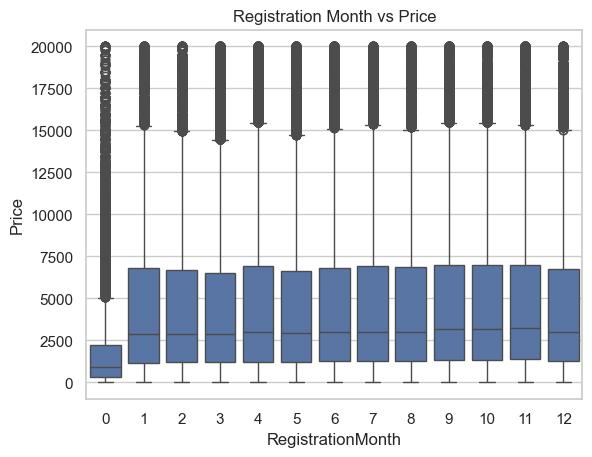

In [108]:
sns.boxplot(data=rusty_df, x='RegistrationMonth', y='Price')
plt.title('Registration Month vs Price')
plt.show()

Once again, there's no discernable correlation between registration month and target. They all have relatively similar quartiles and medians, as well a, similar clusters of outliers. We do have a column of 'month 0', which is likely a typo or a placeholder for null values. Imputing these this categoriy with the mode would likely not change anything--except for the mode itself. Therefore, we can safely drop this column so that we do not use it as a feature in the training and testing of our models.

In [109]:
rusty_df = rusty_df.drop(columns=['RegistrationMonth'])

Let's check to ensure that the RegistrationMonth columns was dropped.

In [110]:
print(rusty_df.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'FuelType', 'Brand', 'NotRepaired',
       'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')


## Checking Mileage Values

Let's check the first few values in our Mileage column.

In [111]:
print(rusty_df['Mileage'].head(10))

0    150000
1    125000
2    125000
3    150000
4     90000
5    150000
6    150000
7     30000
8    150000
9    150000
Name: Mileage, dtype: int64


Mileage is often a significant factor in the value of the car. Typically, as a car gradually increases in mileage, its overall value begins to decrease. Let's see if there is a linear correlation, for this dataframe, between the mileage and pricing of a car.

In [112]:
rusty_df[['Mileage', 'Price']].corr().loc['Mileage', 'Price']

np.float64(-0.3457514838938965)

We have a moderate negative correlation (higher mileage means lower price), which is what we expected. Let's see what the unique values of mileage are.

In [113]:
print(rusty_df['Mileage'].value_counts(dropna=False))

Mileage
150000    233361
125000     35622
100000     14095
90000      11163
80000       9629
70000       8231
60000       7111
50000       5938
5000        5408
40000       4679
30000       4218
20000       3753
10000       1027
Name: count, dtype: int64


It appears that mileage recordings are rounded off. Moreover, due to the large frequency of cars with 150000 miles, this is likely a mileage cap that Rusty Bargain implemented. We do not need to change the values in this column. However, the distribution may be skewed to the right to the point where we need to do a log transformation. Let's take a look.

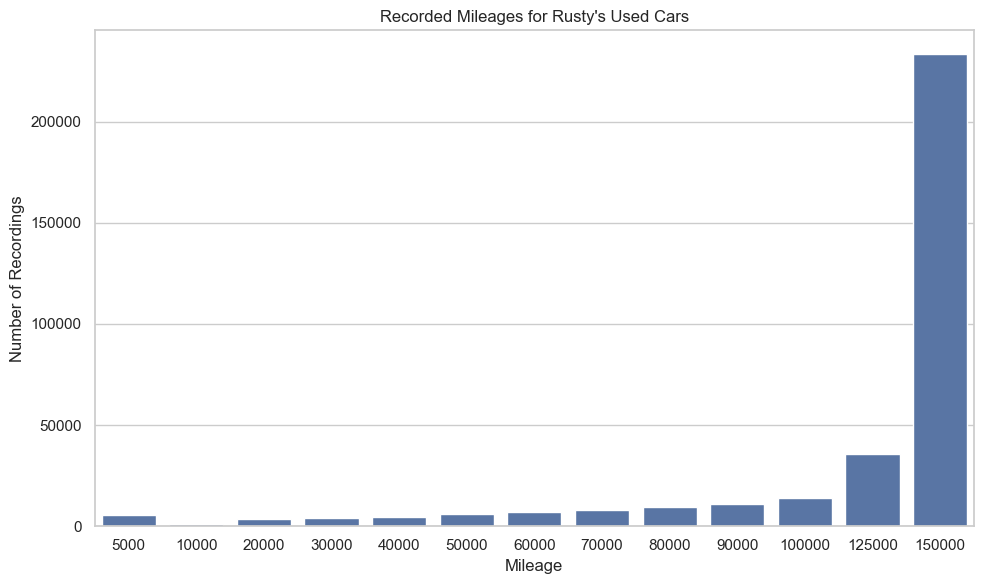

In [114]:
#Setting the background
sns.set(style='whitegrid')

#Establishing the figure
plt.figure(figsize=(10,6))
sns.countplot(x='Mileage', data=rusty_df)

#Adding labels
plt.xlabel("Mileage")
plt.ylabel("Number of Recordings")
plt.title("Recorded Mileages for Rusty's Used Cars")
plt.tight_layout()
plt.show()

In [115]:
#Skewness of distribution
print(rusty_df['Mileage'].skew())

-1.7567982778357263


We clearly see that the distribution is left-skewed so there's no need for a log transformation. The skewness is calculated as -1.72, which is demonstrated by our graph. There's nothing to impute so our feature will remain the same unless we scale it later, which could be important for linear regression.

## Creating Average Prices per Postal Code

Since the postal codes are unordered, categorical values, computing a correlation between itself and the other columns of our dataframe is likely meaningless. However, we could calculate the average prices of cars per postal code, which could be used to determine a meaningful correlation. Let's create this new column in our dataframe.

In [116]:
#Here is the average prices of cars per postal code
average_price_postal_code_series = rusty_df.groupby('PostalCode')['Price'].mean()

#Now we are going to map each of these averages to its respective postal code and store the results in a new column in the dataframe
rusty_df['PostalCodeAveragePrice'] = rusty_df['PostalCode'].map(average_price_postal_code_series)

#Here are the results
print(rusty_df[['PostalCode', 'PostalCodeAveragePrice', 'Price']])

        PostalCode  PostalCodeAveragePrice  Price
0            70435             4733.086207    480
1            66954             3965.877551  18300
2            90480             4984.982759   9800
3            91074             5370.370370   1500
4            60437             5468.366460   3600
...            ...                     ...    ...
344230        2694             2509.586207      0
344231       39576             3451.240506   2200
344232       26135             4136.836879   1199
344233       87439             4924.745283   9200
344234       40764             4374.355469   3400

[344235 rows x 3 columns]


We will use these averages to evaluate correlation against the other columns in the EDA.

## Checking Price (Target) Values

Let's check the first few entries of our target columns (Price).

In [117]:
#First few entires of the price column
print(rusty_df['Price'].head(10))

0      480
1    18300
2     9800
3     1500
4     3600
5      650
6     2200
7    14500
8      999
9     2000
Name: Price, dtype: int64


Let's see the general statistics for this column.

In [118]:
#General statistics for our target
print(rusty_df['Price'].describe())

count    344235.000000
mean       4408.633683
std        4504.013690
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6396.500000
max       20000.000000
Name: Price, dtype: float64


We see that the minimum price of cars is 0, which is likely a typo or some kind of null entry. It would be ideal to filter the price of vehicles to something more realistic, 100 for example. We will check the sum of relative frequencies of prices from 0 - 99 to ensure we do not lose too much data. In addition, the price column has a mean of 4408 and a median of 2700, indicating that we have heavy outliers that are pulling the mean to be bigger than the median. This suggests that our distirbution is skewed right. The spread of this data is also considerable because our standard deviation is 4504. 

Let's check the sum of relative frequences of prices ranging from 0 - 99 so that we may know if it is safe to remove rows in our dataframe that contain any of these prices.

In [119]:
#This is the number of entries in our Price column
price_entries = len(rusty_df['Price'])

#Here is a filtered version of our rusty_df dataframe that only contains the rows which contain prices ranging from 0 - 99.
filtered_prices_df= rusty_df[(rusty_df['Price'] >= 0) & (rusty_df['Price'] < 100)]

#This is the number of rows that our filtered dataframe contains. This is used to calculate the relative frequency.
number_rows_filtered_prices = filtered_prices_df.shape[0]

#Relative frequency calculation
relative_frequency = number_rows_filtered_prices / price_entries

#Result
print(relative_frequency)

0.03578659927084695


The prices ranging from 0 - 99 only compromise of roughly 4% of the data. Therefore, we are going to filter out these prices values so that we get an accurate depiction of our distribution when we graph it.

In [120]:
#Here we filter out the dataframe by have price 100 or more
reasonable_price = rusty_df[rusty_df['Price'] >= 100]

Let's ensure that changes took place and then we can visualize our distribution.

In [121]:
print(reasonable_price['Price'].describe())

count    331916.000000
mean       4572.055788
std        4504.749082
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


Let's take a look at the distribution of values in this target and calculate skewness.

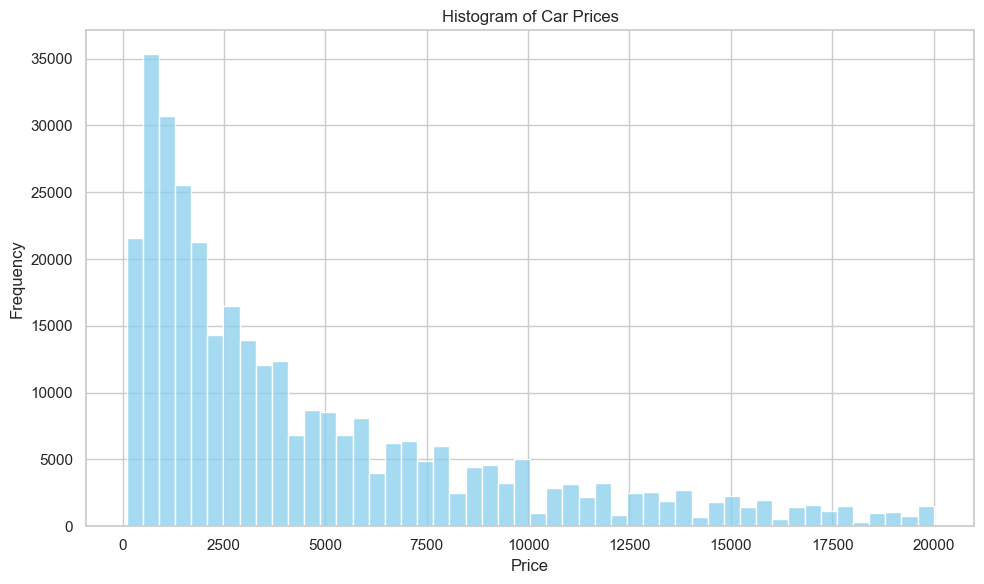

In [122]:
plt.figure(figsize=(10,6))
sns.histplot(data=reasonable_price, x='Price', bins=50, kde=False, color='skyblue')

plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
print(reasonable_price['Price'].skew())

1.4123840032192767


Since our distribution has a skewness of 1.41 and our graph is visually skewed to the right, a log transformation will be implemented since we are using linear regression in our models later on. This helps with the normality assumption with linear regression.

In [124]:
#Here we filter the original dataframe to contain the appropriate price values
rusty_df = rusty_df[rusty_df['Price'] >= 100]

#Log transformation of our prices
rusty_df['LogPrice'] = np.log(rusty_df['Price'])

Now let's compare the distibutions visually and calculate the skewness of the log distribution.

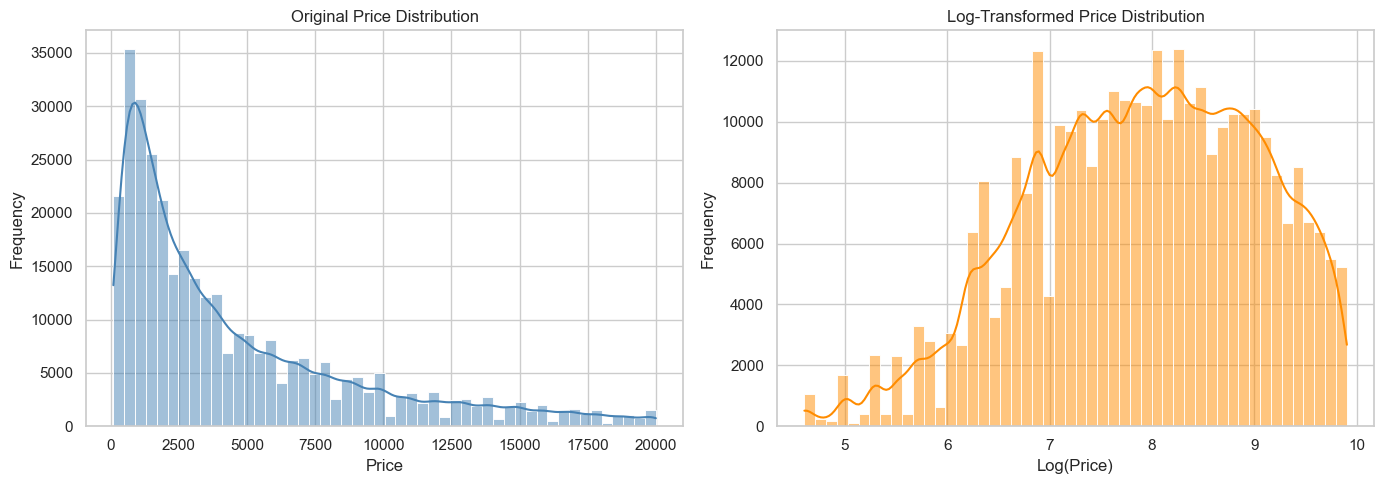

In [125]:
plt.figure(figsize=(14, 5))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=rusty_df, x='Price', bins=50, kde=True, color='steelblue')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=rusty_df, x='LogPrice', bins=50, kde=True, color='darkorange')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [126]:
#Skewness of log prices
print(rusty_df['LogPrice'].skew())

-0.32560104898730097


We now see that our skewness has decreased from 1.41 to -0.32, a good improvement for us when we have to train a linear regression model later.

## Checking Duplicate Rows in Entire Dataframe

Up to this point, we have inspected each column individually for null values / invalid data entries, which were handled using removal of data or imputation. Now we need to check to see if there are any duplicated rows in entire dataframe because there should not be any. If there are, we will remove them.

In [127]:
#Here are the number of duplicated rows we have in our dataframe. This will be used for boolean indexing next
duplicated_rows = rusty_df.duplicated().sum()

#Here we see the first few duplicated rows, if there are any
rusty_df[rusty_df.duplicated()].head(15) if duplicated_rows > 0 else None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,PostalCodeAveragePrice,LogPrice
13904,2016-03-21 19:06:00,5999,small,2009,manual,80.0,polo,125000,petrol,volkswagen,no,2016-03-21,65529,2016-04-05 20:47:00,4053.846154,8.699348
26808,2016-03-23 10:38:00,12200,bus,2011,manual,125.0,zafira,40000,gasoline,opel,no,2016-03-23,26629,2016-04-05 07:44:00,5095.648148,9.409191
30730,2016-04-03 20:41:00,4950,wagon,2003,auto,170.0,e_klasse,150000,gasoline,mercedes_benz,no,2016-04-03,48432,2016-04-05 21:17:00,4242.792593,8.507143
32211,2016-03-07 20:45:00,10900,convertible,2005,auto,163.0,clk,125000,petrol,mercedes_benz,no,2016-03-07,61200,2016-03-21 03:45:00,4427.846154,9.296518
42408,2016-03-13 20:48:00,4200,sedan,2003,manual,105.0,golf,150000,gasoline,volkswagen,no,2016-03-13,14482,2016-03-13 20:48:00,4996.285714,8.342840
46102,2016-03-07 19:42:00,370,sedan,1997,manual,75.0,megane,150000,petrol,renault,no,2016-03-07,38179,2016-03-12 17:47:00,5368.568182,5.913503
47834,2016-03-13 11:38:00,11499,wagon,2011,manual,105.0,passat,125000,gasoline,volkswagen,no,2016-03-13,50354,2016-03-13 11:38:00,5001.570866,9.350015
48394,2016-03-16 10:06:00,4200,small,2007,manual,133.0,yaris,150000,petrol,toyota,no,2016-03-16,55469,2016-03-16 23:21:00,4524.288000,8.342840
51624,2016-03-27 11:58:00,8290,convertible,2000,auto,218.0,slk,150000,petrol,mercedes_benz,no,2016-03-27,79206,2016-04-01 11:18:00,4218.919355,9.022805
51817,2016-03-05 14:12:00,2689,small,2005,auto,61.0,fortwo,90000,petrol,smart,no,2016-03-03,56412,2016-04-05 04:49:00,4226.476562,7.896925


Clearly we have several duplicates that need to be dropped. Of course the first instances will be kept, but any copies will be deleted.

In [128]:
#Here we drop the duplicates in our rust_df dataframe
rusty_df.drop_duplicates(inplace = True)

In [129]:
print(rusty_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 331614 entries, 0 to 344234
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateCrawled             331614 non-null  datetime64[ns]
 1   Price                   331614 non-null  int64         
 2   VehicleType             331614 non-null  object        
 3   RegistrationYear        331614 non-null  int64         
 4   Gearbox                 331614 non-null  object        
 5   Power                   331614 non-null  float64       
 6   Model                   331614 non-null  object        
 7   Mileage                 331614 non-null  int64         
 8   FuelType                331614 non-null  object        
 9   Brand                   331614 non-null  object        
 10  NotRepaired             331614 non-null  object        
 11  DateCreated             331614 non-null  datetime64[ns]
 12  PostalCode              331614 non-

## Checking Duplicate Values in Each Column

For this section, we are going to check the number of duplicates and relative frequency of duplicates for each column. Due to what the data represents, it appears that most of the columns have high duplicate frequencies. Though we are not going to format anything regarding duplicate values for these columns, this information could be helpful in our EDA.

In [130]:
#Here is the length of the dataframe --> used to calculate relative frequency in the denominator
rusty_df_length = len(rusty_df)

#Here is a dictionary that we are going to store the name of the columns with their total duplicates and relative frequency of duplicates
duplicates_dict = {}

for column in rusty_df.columns:
    #This is the number of duplicates we have in the respective column
    number_of_duplicate_values = rusty_df[column].duplicated().sum()

    #This is relative frequency of duplicates
    relative_frequency = (number_of_duplicate_values / rusty_df_length) * 100

    #This is the number of unique values that each columns has
    number_unique_values = rusty_df[column].nunique()

    #Store the results in our dictionary
    duplicates_dict[column] = {'Number of Duplicates': int(number_of_duplicate_values), 'Relative Frequency': float(round(relative_frequency, 2)), 'Unique Values': int(number_unique_values)}

#This is our dataframe that we can display the dictionary contents nicely
duplicates_df = pd.DataFrame.from_dict(duplicates_dict, orient='index')

#Here are the results
display(duplicates_df)

,Number of Duplicates,Relative Frequency,Unique Values
DateCrawled,316300,95.38,15314
Price,327985,98.91,3629
VehicleType,331606,100.00,8
RegistrationYear,331584,99.99,30
Gearbox,331612,100.00,2
Power,331181,99.87,433
Model,331366,99.93,248
Mileage,331601,100.00,13
FuelType,331607,100.00,7
Brand,331574,99.99,40


# Encoding Categorical Columns

When we encode our categorical columns, we will need multiple dataframes that will formatted depending on the model that we are going to train / test. For linear models, our dataframe will include one-hot, binary, and target / frequency encodings. For tree-based models, our dataframe will have binary and target/frequency encondings. Down below we establish these seperate dataframes and keep track of them for the rest of the project.

In [131]:
#Here is the dataframe without any encoding
unencoded_df = rusty_df.copy(deep = True)

#Here is the dataframe for our linear models --> most likely linear regression only
linear_df = rusty_df.copy(deep = True)

#Here is the dataframe for our tree based models --> random forest, XGB boost, et cetera.
tree_df = rusty_df.copy(deep=True)

## Encoding DateCrawled, DateCreated, and LastSeen Columns

We are going to encode all of the datetine type columns by extracting the year for each columns. It is a broader measurement so it will likely be more useful for predictions.

In [132]:
#here are the columns that we are going to extract the year from
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

#Here is the for loop that "encodes" our datetime columns
for col in date_columns:
    linear_df[f'{col}_Year'] = linear_df[col].dt.year
    tree_df[f'{col}_Year'] = tree_df[col].dt.year
    linear_df.drop(columns=[col], inplace=True)
    tree_df.drop(columns=[col], inplace=True)

## Encoding VehicleType and FuelType Columns

Since VehicleType has 8 unique values and FuelType has 7 unique values were neither have any ordering, one-hot encoding will be used for these column.

In [133]:
#Here we encode VehicleType and FuelType using One-Hot encoding for our linear dataframe
linear_df = pd.get_dummies(linear_df, columns=['VehicleType', 'FuelType'], drop_first=True, dtype=int)

#Here we encode VehicleType and FuelType using Label Encoding for our tree based dataframe
label_encoder = LabelEncoder()
tree_df['VehicleType'] = label_encoder.fit_transform(tree_df['VehicleType'])
tree_df['FuelType'] = label_encoder.fit_transform(tree_df['FuelType'])

Even though we used Label Encoding for tree_df, we may use target encoding with cross-validation to improve performance later.

In [134]:
#Here are the results of our changes
print("Linear Dataframe:")
print(linear_df.head(5))
print("\n")
print("Tree Dataframe: ")
print(tree_df.head(5))

Linear Dataframe:
   Price  RegistrationYear Gearbox       Power  Model  Mileage       Brand  \
0    480              1993  manual  120.507226   golf   150000  volkswagen   
1  18300              2011  manual  190.000000   golf   125000        audi   
2   9800              2004    auto  163.000000  grand   125000        jeep   
3   1500              2001  manual   75.000000   golf   150000  volkswagen   
4   3600              2008  manual   69.000000  fabia    90000       skoda   

  NotRepaired  PostalCode  PostalCodeAveragePrice  ...  VehicleType_sedan  \
0          no       70435             4733.086207  ...                  1   
1         yes       66954             3965.877551  ...                  0   
2          no       90480             4984.982759  ...                  0   
3          no       91074             5370.370370  ...                  0   
4          no       60437             5468.366460  ...                  0   

   VehicleType_small  VehicleType_suv  VehicleType

## Encoding Gearbox Column

Since binary encoding is okay for both linear and tree based models, we are going to use binary encoding for the GearBox column and make the same changes to both dataframes.

In [135]:
#Here is the binary encoding for linear_df
linear_df['Gearbox'] = linear_df['Gearbox'].map({'manual': 0, 'auto': 1})
linear_df['NotRepaired'] = linear_df['NotRepaired'].map({'no': 0, 'yes': 1})

#Here is the binary encoding for tree_df
tree_df['Gearbox'] = tree_df['Gearbox'].map({'manual': 0, 'auto': 1})
tree_df['NotRepaired'] = tree_df['NotRepaired'].map({'no': 0, 'yes': 1})

In [136]:
#Here are the results of our changes
print("Linear Dataframe:")
print(linear_df.head(5))
print("\n")
print("Tree Dataframe: ")
print(tree_df.head(5))

Linear Dataframe:
   Price  RegistrationYear  Gearbox       Power  Model  Mileage       Brand  \
0    480              1993        0  120.507226   golf   150000  volkswagen   
1  18300              2011        0  190.000000   golf   125000        audi   
2   9800              2004        1  163.000000  grand   125000        jeep   
3   1500              2001        0   75.000000   golf   150000  volkswagen   
4   3600              2008        0   69.000000  fabia    90000       skoda   

   NotRepaired  PostalCode  PostalCodeAveragePrice  ...  VehicleType_sedan  \
0            0       70435             4733.086207  ...                  1   
1            1       66954             3965.877551  ...                  0   
2            0       90480             4984.982759  ...                  0   
3            0       91074             5370.370370  ...                  0   
4            0       60437             5468.366460  ...                  0   

   VehicleType_small  VehicleType_suv 

## Checking Effect of Model in Pricing

Since the Model column has 248 unique values and has no order, seeing the impact that Model has on Price will be useful in determining how we are going to encode Model for linear_df and tree_df. First, we'll use see the mean price per model. If a model has consistent higher or lower prices, then the model will likely have some kind of predictive power. After this, we'll use a box plot to see if the boxes are far apart, which could indicate that Model influences Price. Last, we can run an ANOVA test to see the p value of Model affecting price.

In [137]:
#Here we are computing the mean price per model
mean_price_per_model = unencoded_df.groupby('Model')['Price'].mean().sort_values()
display(mean_price_per_model)

Model
elefantino      566.900000
lanos           623.197674
move            726.140000
escort          780.253633
seicento        826.849921
                  ...     
q3            15512.307692
a5            15851.797753
q5            16008.354167
glk           16311.920635
gl            18378.833333
Name: Price, Length: 248, dtype: float64

We clearly see that some models have average lower prices while other models have average higher prices. This indicates that Model may affect Price. Let's see a box plot of these columns to get a visual representation of this.

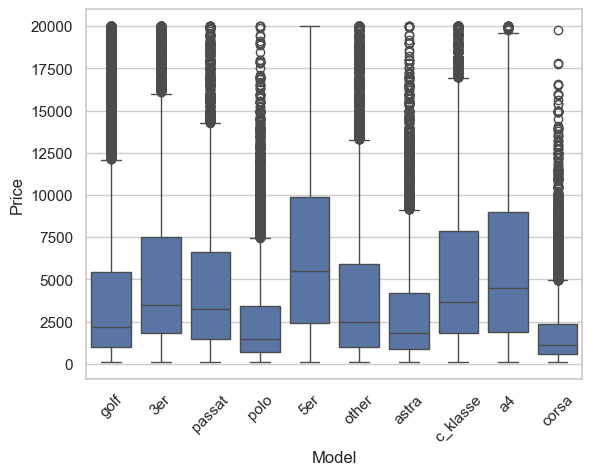

In [138]:
#Here are the top 10 most common models
top_models = unencoded_df['Model'].value_counts().nlargest(10).index

#Here is the box plot
sns.boxplot(x='Model', y='Price', data=unencoded_df[unencoded_df['Model'].isin(top_models)])

#Boxplot specifications
plt.xticks(rotation=45)
plt.show()

We see that he box plots are spread a great deal, demonstrating the Model like affects Price. Let's do an analysis of variance test to see if model likely affect price.

In [139]:
#Here we perform an ANOVA test to check whether the mean Price differs significantly between car Models. 

#We need to get the prices from each Model into an array so that we can perform the ANOVA test
prices_per_model = [subdataframe['Price'].values for name, subdataframe in unencoded_df.groupby('Model')]

#Now we are going to calculate the p-value using the one-way ANOVA test
f_stat, p_value = f_oneway(*prices_per_model)

#F-statistic result
print("F-statistic:", f_stat)

#P-value result
print("P-value: ", p_value)

F-statistic: 543.3772321750727
P-value:  0.0


Clearly the model influences its pricing greatly. This is intuitive in a real-world sense, but we have visually and statistically inferred this to be a realistc expectation. Now we can encode this column using frequency encoding for both linear and tree based models. We know this encoding should not affect the linear regression model since we substantiated our idea that Model affects Price.

## Encoding Model Column

In [140]:
#Here are the frequencies for each of the models
model_frequencies = unencoded_df['Model'].value_counts(normalize=True)

#Encoding Model for linear_df
linear_df['Model_Freq_Encoded'] = linear_df['Model'].map(model_frequencies)

#Encoding Model for tree_df
tree_df['Model_Freq_Encoded'] = tree_df['Model'].map(model_frequencies)

#Results
print(linear_df.head(5))
print("")
print(tree_df.head(5))

   Price  RegistrationYear  Gearbox       Power  Model  Mileage       Brand  \
0    480              1993        0  120.507226   golf   150000  volkswagen   
1  18300              2011        0  190.000000   golf   125000        audi   
2   9800              2004        1  163.000000  grand   125000        jeep   
3   1500              2001        0   75.000000   golf   150000  volkswagen   
4   3600              2008        0   69.000000  fabia    90000       skoda   

   NotRepaired  PostalCode  PostalCodeAveragePrice  ...  VehicleType_small  \
0            0       70435             4733.086207  ...                  0   
1            1       66954             3965.877551  ...                  0   
2            0       90480             4984.982759  ...                  0   
3            0       91074             5370.370370  ...                  1   
4            0       60437             5468.366460  ...                  1   

   VehicleType_suv  VehicleType_wagon  FuelType_electric

## Checking Affect of Brand on Price

It is known that particular car brands have higher priced vehicles than other (Ferrari vs Chevrolet). However, we can do a quick ANOVA test to see if this belief is likely the case.

In [141]:
#Here we are going to get the price values per brand
prices_per_brand = [subframe['Price'].values for brand, subframe in unencoded_df.groupby('Brand')]

#Here we perform one-way ANOVA
f_stat, p_value = f_oneway(*prices_per_brand)

print(f"F-statistics: {f_stat:.2f}")
print(f"P-value (scientific notation): {p_value:.2e}")

F-statistics: 1101.39
P-value (scientific notation): 0.00e+00


We clearly have an extremely low p-value, indicating that it is highly unlikely that price has no difference amongst brands, which implies that brands likely have an impact on their pricing. Let's visualize this with boxplots, as we did with the Model column in the previous section.

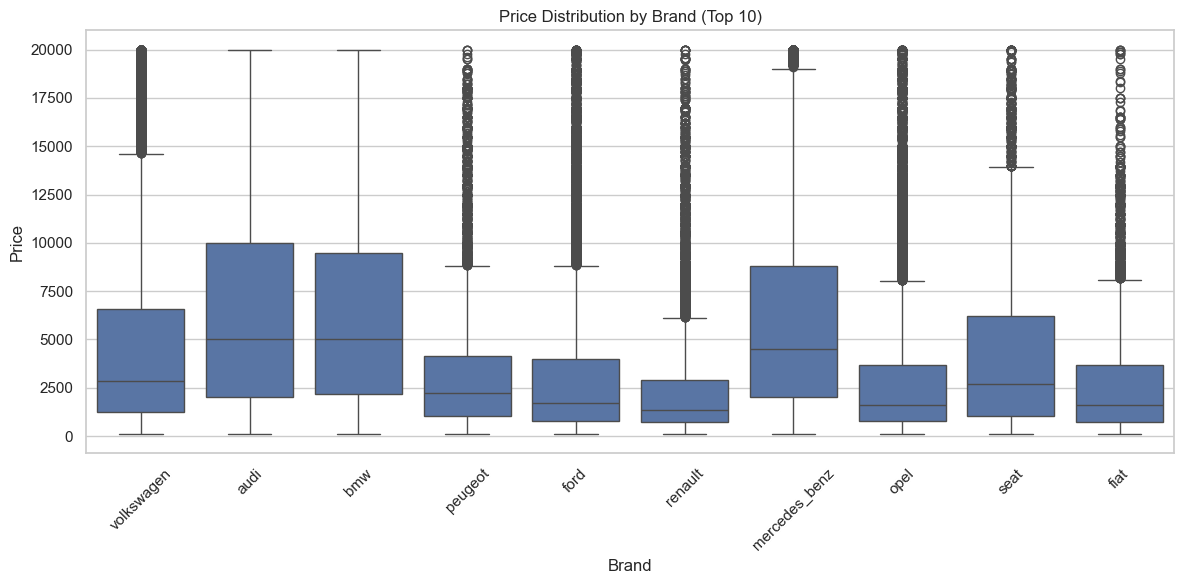

In [142]:
#Here we plot the top 10 most common brands
top_brands = unencoded_df['Brand'].value_counts().head(10).index

#Now we are going to filter a dataframe with only these most common brands --> will help with more compact boxplot
filtered_df = unencoded_df[unencoded_df['Brand'].isin(top_brands)]

#Creating the figure
plt.figure(figsize=(12,6))

#Creating boxplot
sns.boxplot(data=filtered_df, x='Brand', y='Price')

#Boxplot Specs
plt.xticks(rotation=45)
plt.title('Price Distribution by Brand (Top 10)')
plt.tight_layout()
plt.show()

With our column having a considerably low p-value and a diagram that visibly demonstrates that brand have considerably different prices, we can infer that brands highly influence price. For example, Mercedes Benz tend to have higher prices than Fiat.

## Encoding Brand Column

Since we showed that Brand affect Price, we can encode Brand using frequency encoding for both linear_df and tree_df. We do this below.

In [143]:
#Here we are using one-hot encoding for the linear regression --> will increase cardinality by 39 columns, but better for linear models
linear_df = pd.get_dummies(data=rusty_df, prefix='Brand', columns=['Brand'], drop_first=True, dtype=int)

#Here we are using label encoding for tree models --> low dimensionality and safe for tree models
label_encoder = LabelEncoder() #our LabelEncoder object
tree_df['Brand'] = label_encoder.fit_transform(tree_df['Brand'])

#Results
print(linear_df.head(5))
print("")
print(tree_df.head(5))


          DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
0 2016-03-24 11:52:00    480       sedan              1993  manual   
1 2016-03-24 10:58:00  18300       coupe              2011  manual   
2 2016-03-14 12:52:00   9800         suv              2004    auto   
3 2016-03-17 16:54:00   1500       small              2001  manual   
4 2016-03-31 17:25:00   3600       small              2008  manual   

        Power  Model  Mileage  FuelType NotRepaired  ... Brand_seat  \
0  120.507226   golf   150000    petrol          no  ...          0   
1  190.000000   golf   125000  gasoline         yes  ...          0   
2  163.000000  grand   125000  gasoline          no  ...          0   
3   75.000000   golf   150000    petrol          no  ...          0   
4   69.000000  fabia    90000  gasoline          no  ...          0   

   Brand_skoda Brand_smart  Brand_sonstige_autos  Brand_subaru  Brand_suzuki  \
0            0           0                     0             0          

## Encoding NotRepaired Column

Since the NotRepaired column only has yes / no values, binary encoding will work for both dataframes

In [144]:
#Here we do binary encoding for the NotRepaired column in the linear_df dataframe
linear_df['NotRepaired'] = linear_df['NotRepaired'].map({'yes': 1, 'no': 0})

#Here we do binary encoding for the NotRepaired column in the tree_df dataframe
tree_df['NotRepaired'] = tree_df['NotRepaired'].map({'yes': 1, 'no':0})

#Results
print(linear_df.head(5))
print("")
print(tree_df.head(5))

          DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
0 2016-03-24 11:52:00    480       sedan              1993  manual   
1 2016-03-24 10:58:00  18300       coupe              2011  manual   
2 2016-03-14 12:52:00   9800         suv              2004    auto   
3 2016-03-17 16:54:00   1500       small              2001  manual   
4 2016-03-31 17:25:00   3600       small              2008  manual   

        Power  Model  Mileage  FuelType  NotRepaired  ... Brand_seat  \
0  120.507226   golf   150000    petrol            0  ...          0   
1  190.000000   golf   125000  gasoline            1  ...          0   
2  163.000000  grand   125000  gasoline            0  ...          0   
3   75.000000   golf   150000    petrol            0  ...          0   
4   69.000000  fabia    90000  gasoline            0  ...          0   

   Brand_skoda Brand_smart  Brand_sonstige_autos  Brand_subaru  Brand_suzuki  \
0            0           0                     0             0    

# Exploratory Data Analysis

This main purpose of EDA for this project is to evaluate what the features of our models are going to be. The screening for this is relatively straightforward: we are going to check the correlation between potential features and the target. Any potential feature that is weakly correlated (positively or negatively) with the target will be store in a list. Then we will check the correlation amongst the columns themselves. Anything with a high correlation could be removed so that we avoid multcollinearity for our model training.

## Checking Linear Correlation Between Potential Features and Target

In [157]:
#This is our target column for linear_df
target = 'LogPrice'

#Here is the correlations between the potential features and the target column for linear_df
correlations_series = linear_df.corr(numeric_only=True)[target].drop(target)

#Now we are going to filter out the features that have at least a weak (positive or negative) correlation with the target and save it into a list
potential_features = correlations_series[correlations_series.abs() >= 0.15].index.tolist()

#Results
print("Number of potential features:")
print(len(potential_features), "\n")
print("The names of the features:")
print(potential_features)

#Now let's add the target to do potential_features list
potential_features.append(target)

print(potential_features)

Number of potential features:
7 

The names of the features:
['Price', 'RegistrationYear', 'Power', 'Mileage', 'NotRepaired', 'PostalCodeAveragePrice', 'Brand_opel']
['Price', 'RegistrationYear', 'Power', 'Mileage', 'NotRepaired', 'PostalCodeAveragePrice', 'Brand_opel', 'LogPrice']


Now let's take a look at the correlations between the potential features and the target for linear_df.

<Axes: >

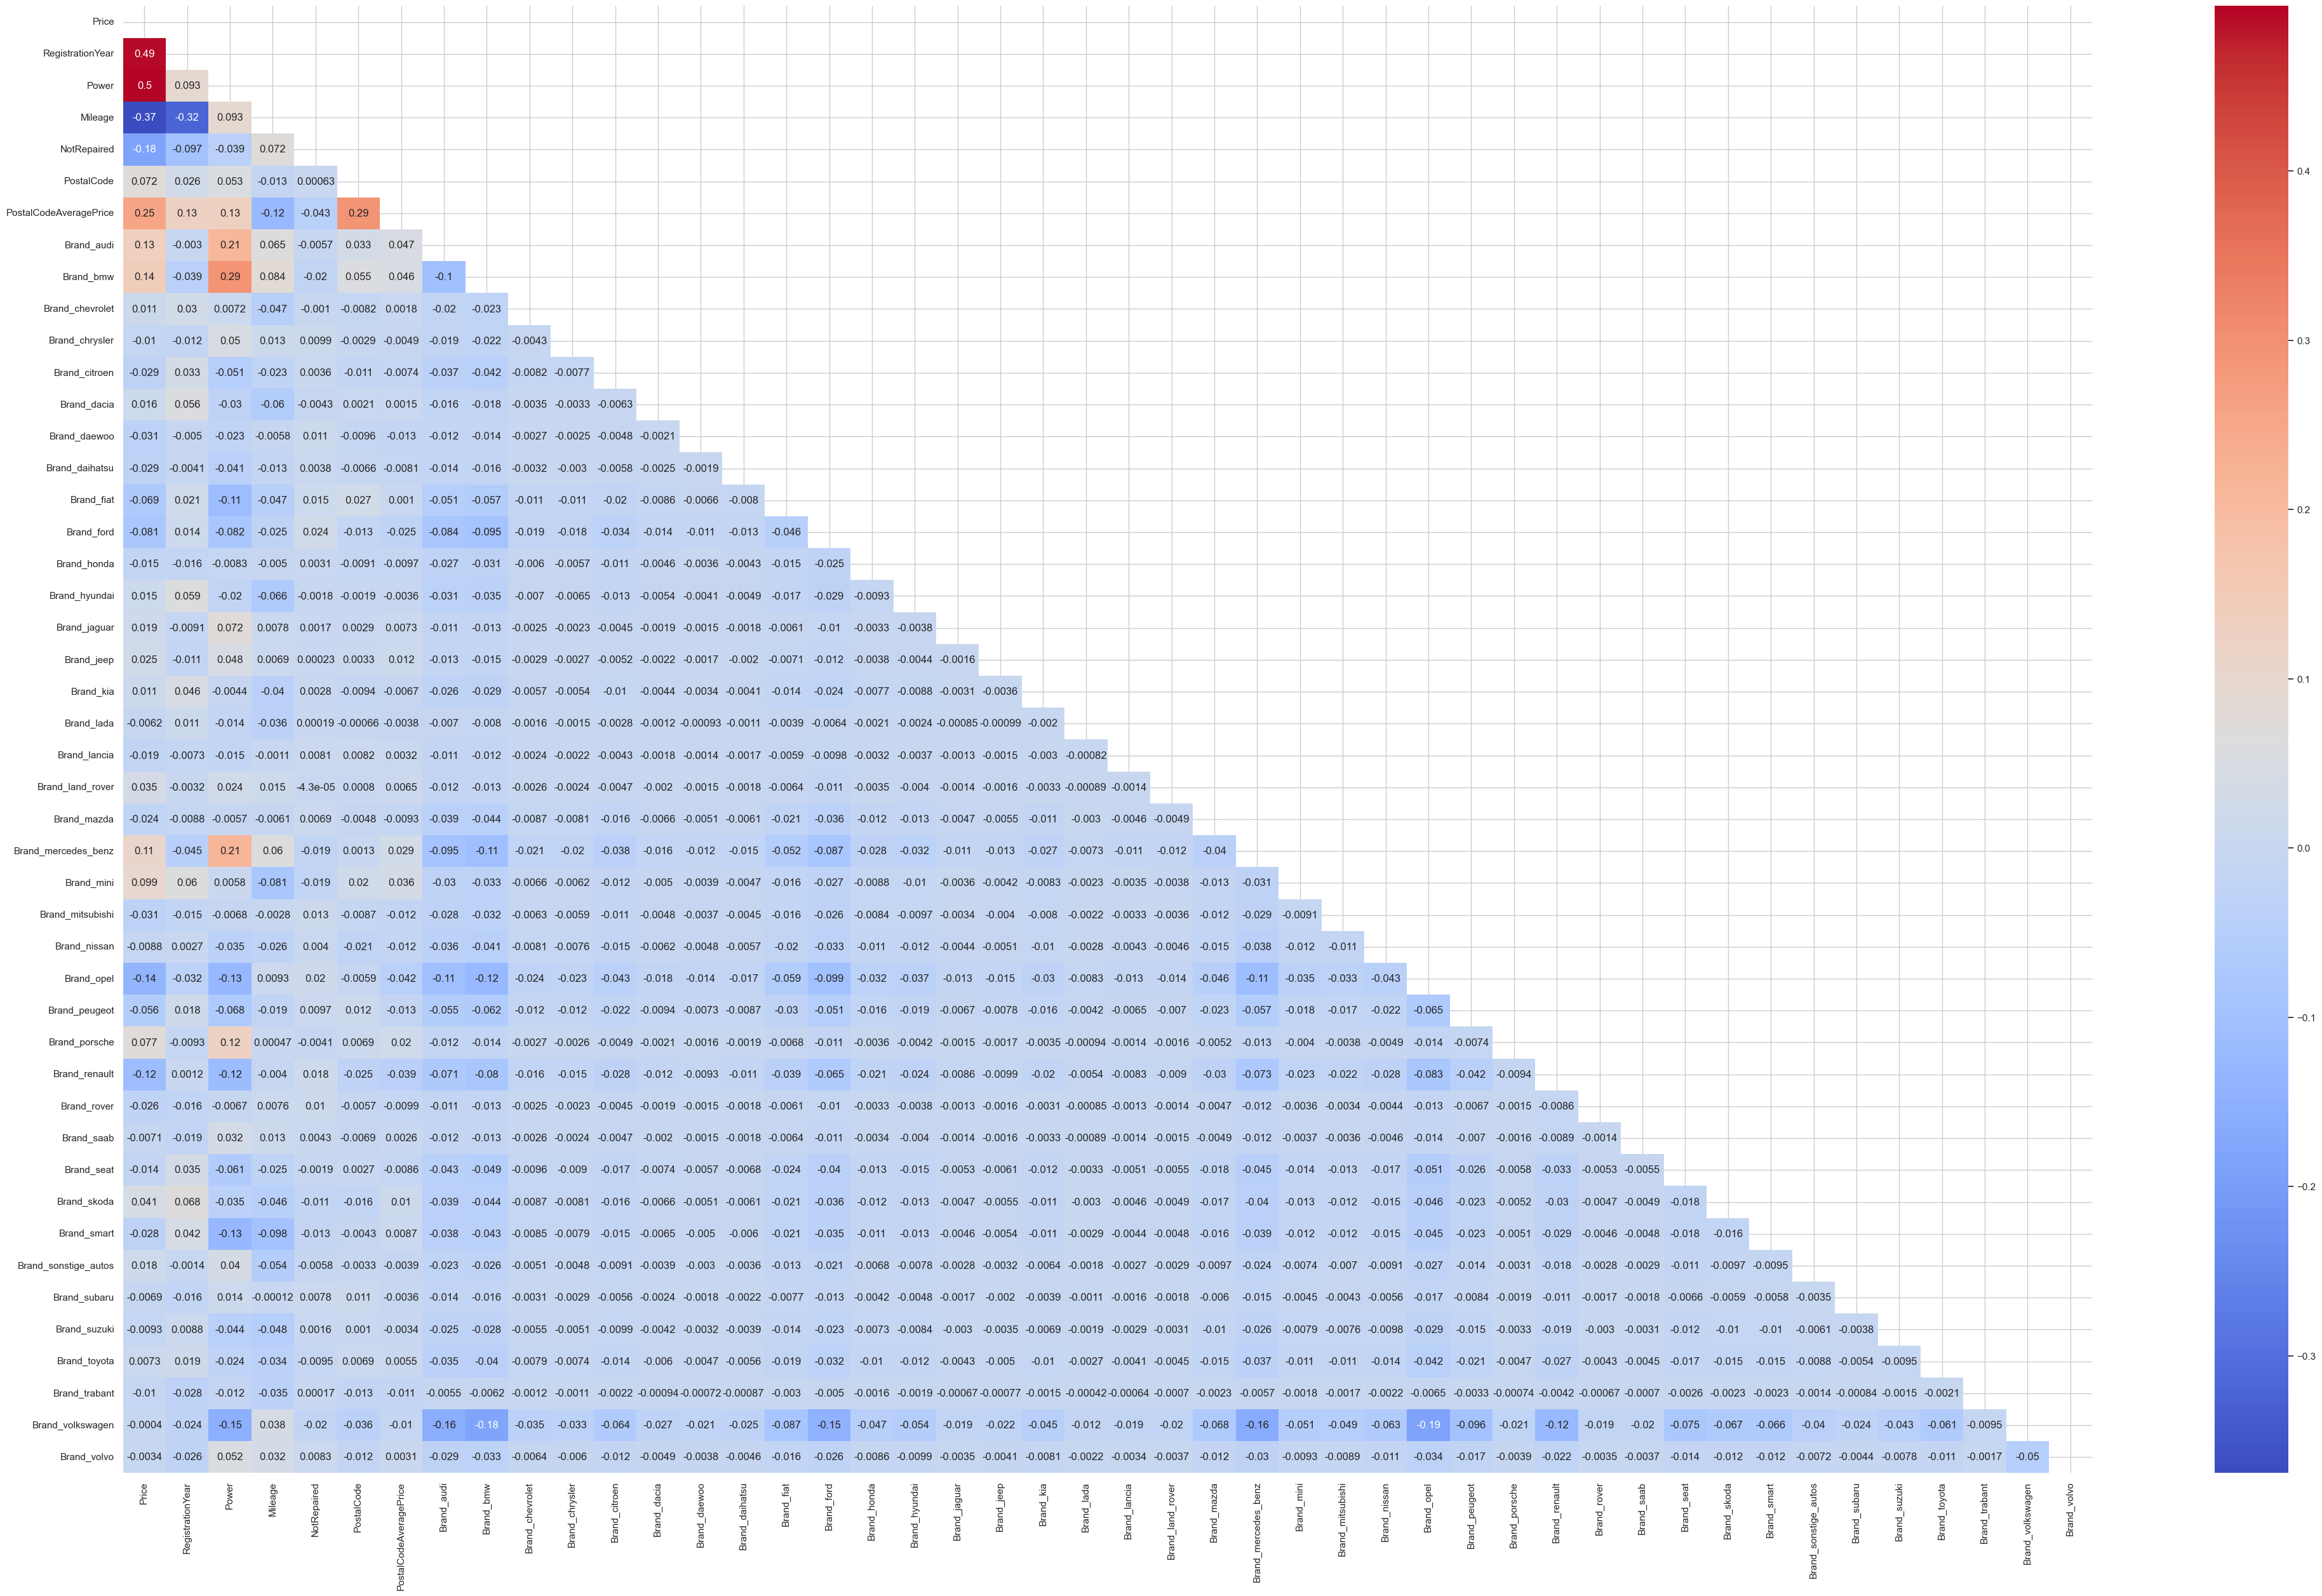

In [156]:
#Here is the correlation matrix of the dataframe that contains the target and potential features
corr = potential_features_df.corr()

#This is our mask that will allow us to filter the lower triangular part of our correlation matrix --> since it is symmetrical anyway
mask = np.triu(np.ones_like(corr, dtype=bool))

#Figure specs
plt.figure(figsize=(50, 30))
sns.heatmap(corr, cmap='coolwarm', mask=mask, annot=True)

To ensure that we avoid multicollinearity, we will check linear correlations between the numerical columns. This is a quick check to see if we need to remove highly correlated column(s).

We see that there are clear correlations between particular columns and our target (Price). The columns that appear to be potential features are registration year (correlation of 0.49), and Power (correlation  of 0.5), Mileage (corrleation of -0.37). There is a weak, positive, linear relationship between average prices for postal codes and prices so we will check to see if there is any kind of correlation later. In addition, we have other categorical columns such as DateCrawled and LastSeen

In [147]:
print(rusty_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 331614 entries, 0 to 344234
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateCrawled             331614 non-null  datetime64[ns]
 1   Price                   331614 non-null  int64         
 2   VehicleType             331614 non-null  object        
 3   RegistrationYear        331614 non-null  int64         
 4   Gearbox                 331614 non-null  object        
 5   Power                   331614 non-null  float64       
 6   Model                   331614 non-null  object        
 7   Mileage                 331614 non-null  int64         
 8   FuelType                331614 non-null  object        
 9   Brand                   331614 non-null  object        
 10  NotRepaired             331614 non-null  object        
 11  DateCreated             331614 non-null  datetime64[ns]
 12  PostalCode              331614 non-

# Model training

## Dropping Columns that Will Not be Used as Features

As mentioned in our "checklist" of things to do to improve our data, we do not need particular columns when training our model. Those columns are the 'PostalCode' and 'Number of Pictures' column. These do not pertain to the value of a car; therefore, we will not need them in the training of our model, which is to predict prices.

# Model analysis

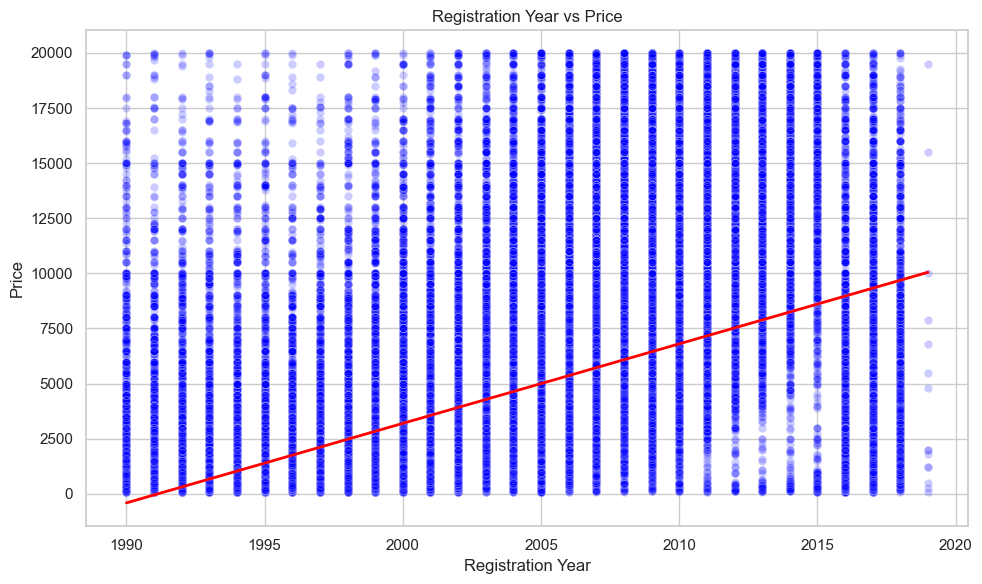

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Transparent scatter plot
sns.scatterplot(
    x='RegistrationYear',
    y='Price',
    data=rusty_df,
    alpha=0.2,
    color='blue'
)

# Overlay regression line
sns.regplot(
    x='RegistrationYear',
    y='Price',
    data=rusty_df,
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)

plt.title('Registration Year vs Price')
plt.xlabel('Registration Year')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed

Scratch Work (Delete Later)

In [149]:
list1 = ['jake']
name = 'target'
list2 = list1 + [name]
print(list2)

['jake', 'target']
